[UMAP](https://umap-learn.readthedocs.io/en/latest/) is a powerful dimensionality reduction tool which NVIDIA recently port GPUs with a python interface.  In this notebook we will demostrate basic usage, plotting, and timing comparisons between the CUDA (GPU) version of UMAP and the original CPU version of UMAP 

In [1]:
import os
import pandas as pd
import numpy as np

# CPU UMAP
import umap

# libraries for scoring/clustering
import hdbscan
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

# GPU UMAP
import cudf
from cuml.manifold.umap import UMAP as cumlUMAP

# plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(25, 12.5)})

In [2]:
# hide warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

We are going to work with the [fashion mnist](https://github.com/zalandoresearch/fashion-mnist) data set.  This is a dataset consisting of 70,000 28x28 grayscale images of clothing.

In [3]:
if not os.path.exists('fashion_mnist'):
    !git clone https://github.com/zalandoresearch/fashion-mnist.git fashion_mnist

In [4]:
# https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [5]:
train, train_labels = load_mnist('fashion_mnist/data/fashion', kind='train')
test, test_labels = load_mnist('fashion_mnist/data/fashion', kind='t10k')
data = np.array(np.vstack([train, test]), dtype=np.float64) / 255.0
target = np.array(np.hstack([train_labels, test_labels]))

There are 60000 training images and 10000 test images

In [6]:
f"Train shape: {train.shape} and Test Shape: {test.shape}"

'Train shape: (60000, 784) and Test Shape: (10000, 784)'

In [7]:
train[0].shape

(784,)

As mentioned previously, each row in the train matrix is an image

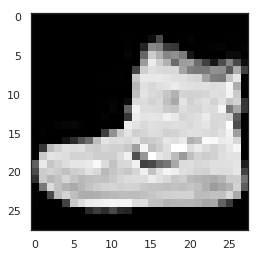

In [8]:
# display a Nike? sneaker
pixels = train[0].reshape((28, 28))
plt.imshow(pixels, cmap='gray')

There is cost between moving data between host memory and device memory (GPU memory) and we will include that core when comparing speeds

In [13]:
%%timeit
record_data = (('fea%d'%i, data[:,i]) for i in range(data.shape[1]))
gdf = cudf.DataFrame(record_data)
g_embedding = cumlUMAP(n_neighbors=5, init="spectral").fit_transform(gdf)

18.4 s ± 202 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


`gdf` is a GPU backed dataframe -- all the data is store in the device memory of the GPU.  With the data converted, we can apply UMAP with *naive* inputs.  We can improve the `cumlUMAP` constructor by doing the `data->gdf` conversion automatically.  Additionally, it should be noted that within cuml, [FAISS](https://github.com/facebookresearch/faiss) is used for extremely fast kNN and it's limited to single precision.  `cumlUMAP` will automatically downcast to `float32` when needed

In [14]:
%%timeit
embedding = umap.UMAP(n_neighbors=5, init="spectral").fit_transform(data)

/home/nfs/bzaitlen/miniconda3/envs/cudf-dev/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components
/home/nfs/bzaitlen/miniconda3/envs/cudf-dev/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


1min 41s ± 491 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Compute Runtimes of UMAP (lower is better):
- host->device memory + cumlUMAP (GPU): 18.4
- UMAP (CPU): 101 seconds

cumlMAP is ~5.5x speed up over UMAP CPU.  Let's also compare qualitatively compare output accuracy

In [17]:
embedding = umap.UMAP(n_neighbors=5, init="spectral").fit_transform(data)
record_data = (('fea%d'%i, data[:,i]) for i in range(data.shape[1]))
gdf = cudf.DataFrame(record_data)
g_embedding = cumlUMAP(n_neighbors=5, init="spectral").fit_transform(gdf)

In [18]:
classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']

Just as the original author of UMAP Leland McInnes does in the [UMAP docs](https://umap-learn.readthedocs.io/en/latest/supervised.html), we can plot the results and show the separation bewtween the various classes defined above.

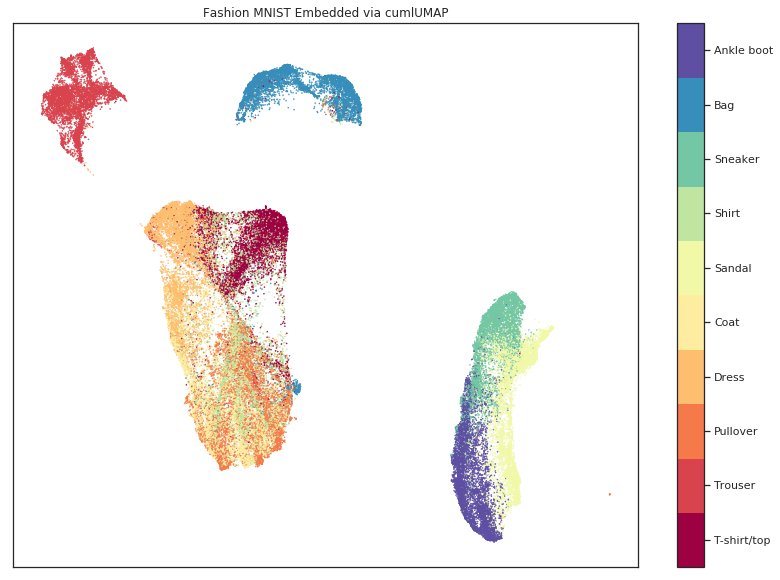

In [19]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(g_embedding[:,1], g_embedding[:,0], s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via cumlUMAP');

And side-by-side we can see the separation is very similar between both GPU and CPU versuion of UMAP.  Both cluster Ankle Boot, Sneaker, and Sandal together (Green/Yellow/Purple), both separate Trousers and Bags entirely, and both have T-shirts, Shirts, Coats, etc. all mixed toether.

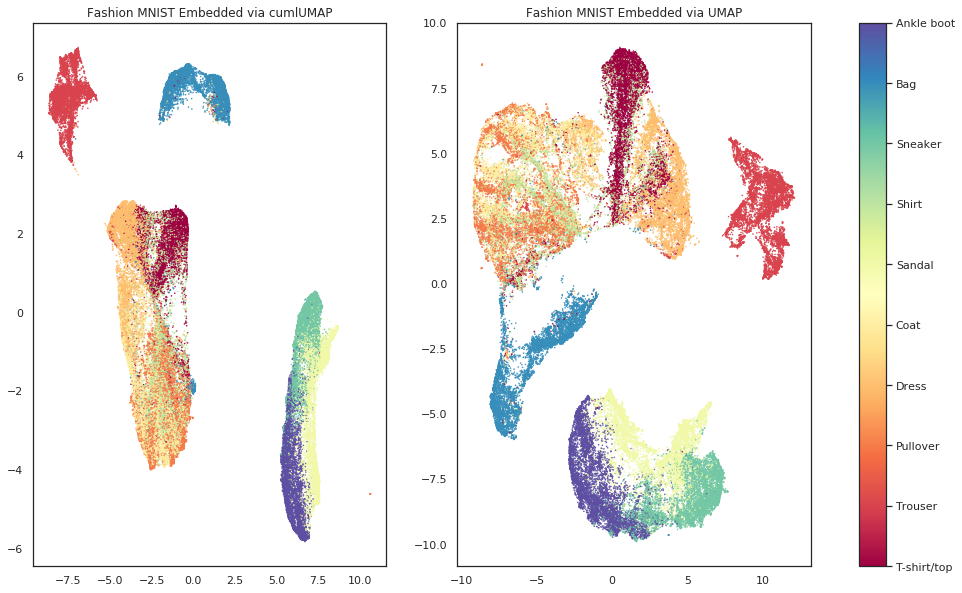

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].scatter(g_embedding[:,1], g_embedding[:,0], s=0.3, c=target, cmap='Spectral', alpha=1.0)
im = ax[1].scatter(embedding[:,1], embedding[:,0], s=0.3, c=target, cmap='Spectral', alpha=1.0)
ax[0].set_title('Fashion MNIST Embedded via cumlUMAP');
ax[1].set_title('Fashion MNIST Embedded via UMAP');

fig.subplots_adjust(right=0.8)
cax,kw = mpl.colorbar.make_axes([a for a in ax.flat])
cbar = plt.colorbar(im, cax=cax, **kw)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

Additionally, we can also quanititaviely measure the scoring performance of hdbscan on GPU/CPU version of UMAP

In [21]:
# CPU VERSION
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(embedding)
clustered = (labels >= 0)
(
    adjusted_rand_score(target[clustered], labels[clustered]),
    adjusted_mutual_info_score(target[clustered], labels[clustered], average_method='arithmetic')
)

(0.4131634144814221, 0.6514631493379099)

In [22]:
# GPU VERSION
g_labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(g_embedding)
clustered = (labels >= 0)
(
    adjusted_rand_score(target[clustered], g_labels[clustered]),
    adjusted_mutual_info_score(target[clustered], g_labels[clustered], average_method='arithmetic')
)

(0.28664359036551756, 0.6087726799929682)